> Sequential 모델 layer 구조 변경

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **모듈 설치**

In [ ]:
# ! pip uninstall JPype1
# ! pip install JPype1-py3

In [ ]:
# konlpy 설치
! pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# install mecab
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.


In [ ]:
! ls

drive  Mecab-ko-for-Google-Colab  sample_data


In [ ]:
#move to Mecab-ko~ folder
! cd Mecab-ko-for-Google-Colab/

In [ ]:
! bash install_mecab-ko_on_colab190912.sh

bash: install_mecab-ko_on_colab190912.sh: No such file or directory


In [ ]:
from konlpy.tag import Kkma, Komoran, Okt, Mecab

mec = Mecab()
okt = Okt()
kkm = Kkma()
kom = Komoran()

---

In [ ]:
# # Colab에서 오류 없이 Mecab 설치: https://sosomemo.tistory.com/31
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

### **데이터 준비**

In [ ]:
import pandas as pd

# df = pd.read_csv('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.csv', index_col=0)
df = pd.read_table('/content/drive/MyDrive/AIFFELTHON/AIFFELTHON_BBC/moonee_qna_set.txt', sep=',', index_col=0)
# df.head()

> 정수 인코딩

In [ ]:
sub_type_mapping = {
    '내비게이션': 0,
    '타이어': 1,
    '라이트': 2,
    '시동': 3,
    '경고등': 4,
    '차량외부': 5,
    '차량내부': 6,
    '주행관련': 7,
    '사고조사': 8,
    '단말기': 9,
    '주유/충전카드': 10,
    '후방카메라': 11,
    '하이패스': 12,
    '차량점검': 13,
    '브레이크': 14,
    '블랙박스': 15,
    '위생문제': 16,
    '주차장': 17,
    'ADAS': 18,
    '비치품': 19,
    '충전기확인': 20
}

func = lambda x: sub_type_mapping.get(x, x)

In [ ]:
df['sub_type'] = df['sub_type'].map(func)

In [ ]:
# df.head()

#### **train, test set 분리**

In [ ]:
print('전체 길이: ', len(df))
print('80% 길이: ', len(df)*0.8)

전체 길이:  5842
80% 길이:  4673.6


In [ ]:
from sklearn.model_selection import train_test_split

# train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=2)

In [ ]:
# drop=True 안 하면 index 열 안 사라짐
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
# 이거 안 맞아서 애먹음 ^^..
df_train['sub_type'].nunique(), df_test['sub_type'].nunique()

(21, 21)

### **데이터 로더 구성**
- ~데이터 중복 제거~
- ~NaN 결측치 제거~
- 한국어 토크나이저로 토큰화
- 불용어(stopwords) 제거
- 사전 `word_to_index` 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환

In [ ]:
from konlpy.tag import Mecab # 한국어 형태소 토큰화를 위해 형태소 분석기 중 mecab 사용
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(df_train, df_test, num_words=2774):
    # df_train.drop_duplicates(subset=['inquiry'], inplace=True) # 중복 제거
    df_train = df_train.dropna(how='any') # 결측치 하나라도 있으면 제거
    # df_test.drop_duplicates(subset=['inquiry'], inplace=True)
    df_test = df_test.dropna(how='any')
    
    X_train = []
    for sentence in df_train['inquiry']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    print(X_train)
        
    X_test = []
    for sentence in df_test['inquiry']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) # 각 요소의 개수 다루고 싶을 때
    counter = counter.most_common(2774-4) # 빈도순으로 높은 9996개 리스트 안의 튜플로 반환
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] # vocab 저장
    # print(vocab)
    word_to_index = {word: index for index, word in enumerate(vocab)}
    # print(word_to_index)

    def wordlist_to_indexlist(wordlist): # 텍스트 스트링을 사전 인덱스 스트링으로
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(df_train['sub_type'])), X_test, np.array(list(df_test['sub_type'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(df_train, df_test)

In [ ]:
load_data(df_train, df_test)

In [ ]:
X_train

[[96, 97, 243, 310, 60, 49, 21, 37, 111, 963, 194, 85, 30],
 [50, 52, 53, 6, 106, 11],
 [23, 6, 244, 5],
 [123,
  674,
  292,
  622,
  327,
  622,
  26,
  293,
  1541,
  108,
  328,
  292,
  1542,
  351,
  964,
  577,
  340,
  1543,
  41,
  5],
 [14, 7, 4, 15, 4, 5],
 [24, 65, 13, 5],
 [63, 140, 58, 108, 329, 222, 838, 66, 542, 5],
 [47, 99, 13],
 [63, 140, 58, 108, 1148, 1544, 183],
 [8, 94, 90, 38, 28, 95, 5],
 [27, 7, 4, 15, 4],
 [8, 63, 747, 172, 5],
 [103, 149],
 [27, 7, 4, 15, 4],
 [39, 74, 7, 4, 15, 4],
 [8, 263, 352, 14, 27, 7, 4, 34, 9, 12, 5],
 [245, 79, 76, 166, 23, 13],
 [31, 119, 14, 27, 7, 4, 15, 4, 5],
 [39, 7, 4, 15, 4, 5],
 [107, 101, 80, 94, 8, 28, 18],
 [1149, 144, 117, 81, 1149],
 [133, 4, 46, 7, 4, 34, 9, 12, 5],
 [37, 13, 25, 69, 5],
 [8, 407, 26, 23, 6, 330, 5],
 [278, 7, 4, 423, 48],
 [70, 72, 56, 104, 5],
 [121, 259, 56, 9, 20, 22, 18, 5],
 [47, 238, 10, 26, 47, 38, 28, 19, 89, 26, 269, 173, 10, 135],
 [96, 7, 4, 15, 4, 9, 61, 48],
 [195, 7, 4, 331, 41, 5],
 [2

In [ ]:
len(df_train)

4673

In [ ]:
len(X_train), len(X_test)

(4667, 1169)

In [ ]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [ ]:
type(X_train), type(y_train)

(list, numpy.ndarray)

In [ ]:
index_to_word = {index: word for word, index in word_to_index.items()}

In [ ]:
len(index_to_word)

2774

In [ ]:
def to_one_hot(labels, dimension=21):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(y_train)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(y_test)

In [ ]:
one_hot_train_labels.shape, one_hot_test_labels.shape

((4667, 21), (1169, 21))

In [ ]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

In [ ]:
one_hot_train_labels.shape, one_hot_test_labels.shape

((4667, 21), (1169, 21))

In [ ]:
# 변수명 change
y_train = one_hot_train_labels
y_test = one_hot_test_labels

In [ ]:
y_train.shape, y_test.shape

((4667, 21), (1169, 21))

In [ ]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 하자.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word]
        if word in word_to_index else word_to_index['<UNK>'] 
            for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] 
        if index in index_to_word else '<UNK>' 
            for index in encoded_sentence[1:]) # [1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### **모델 구성을 위한 데이터 분석 및 가공**
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- `keras.preprocessing.sequence.pad_sequences`을 활용한 패딩 추가

In [ ]:
total_data_text = list(X_train) + list(X_test)
# 텍스트 데이터 문장길이의 리스트 생성

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균값, 최대값, 표준편차 계산해보자
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)

print('padd_sequences maxlen: ', maxlen)
print('\n전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균:  9.511651816312543
문장길이 최대:  169
문장길이 표준편차:  8.2479586823479
padd_sequences maxlen:  26

전체 문장의 0.9602467443454421%가 maxlen 설정값 이내에 포함됩니다.


In [ ]:
# 위에서 설정한 maxlen 이용하기
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)
print(X_train.shape)

(4667, 26)


### **Validation set 구성**

In [ ]:
# validation set 600건 분리
X_val = X_train[:600]
y_val = one_hot_train_labels[:600]

# validation set을 제외한 나머지
partial_X_train = X_train[600:]
partial_y_train = one_hot_train_labels[600:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(4067, 26)
(4067, 21)


In [ ]:
# vocab_size = 2774 # 어휘 사전의 크기 (10,000개의 단어)
# word_vector_dim = 32 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터) // (높을수록 상세하게 분류) 우린 단어가 많지 않으므로

# # model 설계
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.LSTM(32)) # 가장 널리 쓰이는 LSTM레이어 (이 때 LSTM state 벡터의 차원수는 8로 함 - 변경 가능)
# model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dense(21, activation='softmax')) # 최종 출력은 긍정/부정을 나타내는 1차원

# model.summary()

vocab_size = 2774 # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 64 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터) // (높을수록 상세하게 분류) 우린 단어가 많지 않으므로

# model 설계
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.LSTM(32)) # 가장 널리 쓰이는 LSTM레이어 (이 때 LSTM state 벡터의 차원수는 8로 함 - 변경 가능)
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(21, activation='softmax')) # 최종 출력은 긍정/부정을 나타내는 1차원

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, None, 64)          177536    
                                                                 
 conv1d_18 (Conv1D)          (None, None, 64)          12352     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_19 (Conv1D)          (None, None, 64)          12352     
                                                                 
 global_max_pooling1d_19 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 32)              

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# partial_y_train, y_val 얘네를 (~, 21)로 맞춰야 해 !!!!!!!!!!!!
# -> 애초에 y_train이 (~, )였음 -> 얘를 (~, 21)로 해야 함 ㅜㅜ

print(partial_X_train.shape, partial_y_train.shape, X_val.shape, y_val.shape)

(4067, 26) (4067, 21) (600, 26) (600, 21)


In [ ]:
epochs = 30 # 몇 epoch를 훈련하면 좋을지 결과 보며 바꾸기

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/30
64/64 [==============================] - 2s 10ms/step - loss: 2.5653 - accuracy: 0.2009 - val_loss: 2.1219 - val_accuracy: 0.3850
Epoch 2/30
64/64 [==============================] - 0s 7ms/step - loss: 1.8003 - accuracy: 0.4780 - val_loss: 1.4729 - val_accuracy: 0.5917
Epoch 3/30
64/64 [==============================] - 0s 6ms/step - loss: 1.3018 - accuracy: 0.6371 - val_loss: 1.1838 - val_accuracy: 0.7100
Epoch 4/30
64/64 [==============================] - 0s 7ms/step - loss: 1.0460 - accuracy: 0.7332 - val_loss: 1.0173 - val_accuracy: 0.7467
Epoch 5/30
64/64 [==============================] - 0s 7ms/step - loss: 0.8771 - accuracy: 0.7760 - val_loss: 0.9539 - val_accuracy: 0.7500
Epoch 6/30
64/64 [==============================] - 0s 7ms/step - loss: 0.7717 - accuracy: 0.7952 - val_loss: 0.9116 - val_accuracy: 0.7617
Epoch 7/30
64/64 [==============================] - 0s 7ms/step - loss: 0.6883 - accuracy: 0.8239 - val_loss: 0.9360 - val_accuracy: 0.7467
Epoch 8/30
64/64 [=

In [ ]:
# 학습이 끝난 모델 테스트셋으로 평가해보기
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

37/37 - 0s - loss: 1.6858 - accuracy: 0.7160 - 103ms/epoch - 3ms/step
[1.685806155204773, 0.7159965634346008]


### **RNN - Loss, Accuracy 그래프 시각화**

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


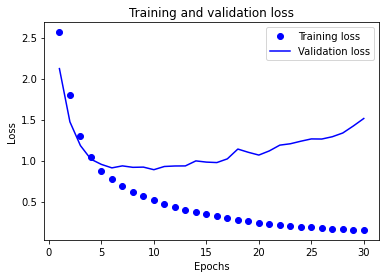

In [ ]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

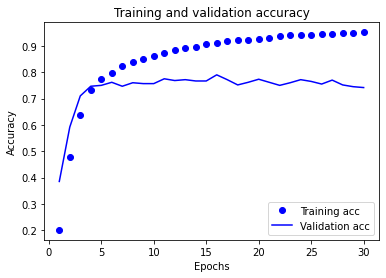

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

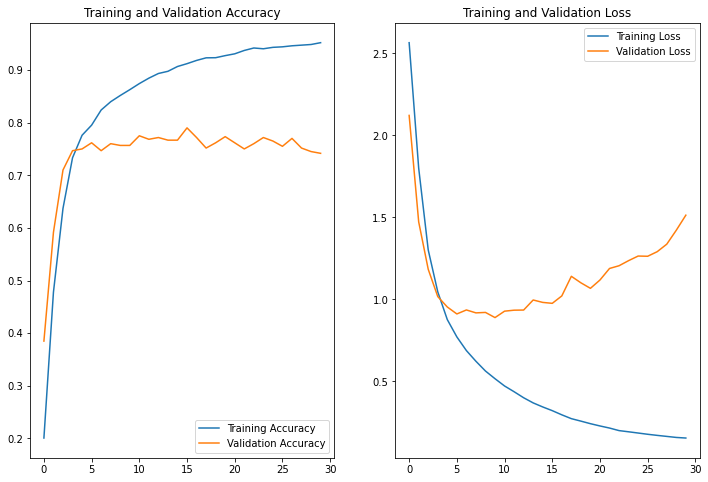

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

### **1-D CNN 모델**

### **한국어 Word2Vec 임베딩 활용하여 성능 개선**

In [ ]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(2774, 64)


In [ ]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장하기
word2vec_file_path = '/content/drive/MyDrive/AIFFELTHON/정연/word2vec_yeon.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개 제외)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
  f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :]))))) # 왜 에러 뜨냐고오오오옥

f.close()

In [ ]:
index_to_word[5], ' '.join(map(str, vectors[5, :]))

('인입',
 '0.04731153 0.15067463 0.051309712 0.09789841 0.102066755 -0.09666232 -0.12382733 -0.0157558 -0.056491677 -0.01656454 0.10659889 0.03231078 0.046629637 -0.07460464 -0.0031082109 0.124156184 0.074456185 0.06381219 0.077138565 -0.021187492 0.031001797 0.040370673 0.04897269 -0.012760106 0.07177655 0.07024993 -0.12024264 0.037723154 0.111015506 0.047496453 0.2170945 0.028314792 -0.04272204 -0.053728472 -0.0834354 -0.25079125 -0.04005009 -0.02579792 0.09838513 0.04956875 -0.020858414 -0.15798779 0.045491267 0.06750344 0.06900623 0.029589389 -0.07083961 0.03919983 -0.017051788 -0.048826486 0.06968128 -0.09839719 -0.0018435422 0.036470667 0.05833124 0.076661915 -0.053058293 0.07289081 0.008581187 0.010145622 -0.07415079 -0.023657588 -0.0072071054 0.036574464')

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['내비게이션'] # 한글로 확인
vector

array([-0.07398853,  0.09358838, -0.13726601, -0.15182313, -0.20726769,
        0.06472518,  0.05242985,  0.15055354,  0.05726146,  0.0552138 ,
       -0.08917945, -0.15963407,  0.04368017, -0.13047278,  0.00037549,
        0.15082115, -0.1867375 ,  0.17083013,  0.19141494,  0.16052428,
       -0.17263983, -0.06661207, -0.02519292,  0.0213069 , -0.13598885,
       -0.05870824,  0.14500943,  0.15584078, -0.01520359, -0.11239754,
       -0.01988835,  0.16580771, -0.1888991 ,  0.05162024, -0.19628574,
       -0.07447309, -0.1616774 ,  0.1731019 , -0.03204874,  0.08537754,
        0.07676946,  0.20440112,  0.19477443,  0.18323538, -0.04688644,
        0.14224581, -0.15738934,  0.18190248,  0.04619036, -0.06406028,
       -0.11522464,  0.07947127, -0.19347349,  0.00501998, -0.13696419,
        0.1473433 , -0.04442098, -0.19999757,  0.08876199, -0.13997865,
       -0.09010757,  0.12320442,  0.13211913, -0.12539835], dtype=float32)

In [ ]:
word_vectors.similar_by_word("내비게이션")

[('음성', 0.8670773506164551),
 ('TCS', 0.8636333346366882),
 ('네비', 0.8505269289016724),
 ('거치대', 0.8266932368278503),
 ('종료', 0.801209568977356),
 ('티맵', 0.7958481311798096),
 ('업데이트', 0.7936642169952393),
 ('경로', 0.784880518913269),
 ('내비', 0.7795783877372742),
 ('부팅', 0.7759361267089844)]

In [ ]:
word_vectors.similar_by_word("타이어")

[('압점', 0.8620724678039551),
 ('TPMS', 0.8536317348480225),
 ('펑크', 0.8350433111190796),
 ('파스', 0.8288185596466064),
 ('육안', 0.8268115520477295),
 ('접촉', 0.8205269575119019),
 ('펑', 0.8191430568695068),
 ('바람', 0.8089561462402344),
 ('전좌', 0.8084698915481567),
 ('우려', 0.8025476932525635)]

### **예측해보기**

In [ ]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from konlpy.tag import Okt

okt = Okt()
mecab = Mecab()
tokenizer = Tokenizer()
# tokenizer = Tokenizer(num_words = 2774, oov_token="<OOV>")


In [ ]:
sub_type_mapping = {
    0 : '내비게이션',
    1 : '타이어',
    2 : '라이트',
    3 : '시동',
    4 : '경고등',
    5 : '차량외부',
    6 : '차량내부',
    7 : '주행관련',
    8 : '사고조사',
    9 : '단말기',
    10 : '주유/충전카드',
    11 : '후방카메라',
    12 : '하이패스',
    13 : '차량점검',
    14 : '브레이크',
    15 : '블랙박스',
    16 : '위생문제',
    17 : '주차장',
    18 : 'ADAS',
    19 : '비치품',
    20 : '충전기확인'
}

In [ ]:
def subtype_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

  tokenizer = Tokenizer(num_words=2774, oov_token="<OOV>")
  tokenizer.fit_on_texts(new_sentence)

  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded
                          , maxlen=maxlen) # 패딩


  # 참조: https://wiserloner.tistory.com/525
  # argsort: 넘파이 배열의 원소를 오름차순 정렬하는 메소드. 반환 값은 배열의 인덱스
  score = model.predict(pad_new)[0]
  # print(score)
  sort_index = (-score).argsort() # 내림차순 정렬

  for i in sort_index:
    print(sub_type_mapping.get(i))
    # label = [key for key, value in sub_type_mapping.items() if value == i][0]
    # print(label)

  # score = float(model.predict(pad_new)) # 예측

  # if(score > 0.5):
  #   print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  # else:
  #   print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
subtype_predict('내비게이션이 안 됩니다')

경고등
라이트
시동
타이어
ADAS
내비게이션
주행관련
사고조사
주유/충전카드
단말기
차량점검
충전기확인
블랙박스
차량내부
브레이크
후방카메라
위생문제
차량외부
비치품
하이패스
주차장


In [ ]:
subtype_predict('타이어')

주행관련
차량외부
브레이크
경고등
비치품
단말기
위생문제
후방카메라
내비게이션
타이어
시동
라이트
차량점검
차량내부
충전기확인
ADAS
주차장
블랙박스
주유/충전카드
사고조사
하이패스


In [ ]:
subtype_predict('내비게이션이 t맵 실행준비중으로만 나오고 작동 되지 않음')

경고등
라이트
타이어
시동
ADAS
주행관련
위생문제
단말기
차량외부
후방카메라
비치품
차량점검
내비게이션
주차장
차량내부
브레이크
블랙박스
충전기확인
사고조사
주유/충전카드
하이패스


In [ ]:
subtype_predict('시동불가')

타이어
차량외부
주행관련
라이트
내비게이션
차량내부
경고등
위생문제
시동
주차장
단말기
비치품
후방카메라
차량점검
ADAS
브레이크
블랙박스
주유/충전카드
하이패스
사고조사
충전기확인


In [ ]:
subtype_predict('내비게이션 와이파이가 잘 안 됩니다.')

라이트
타이어
경고등
주행관련
시동
비치품
ADAS
차량점검
위생문제
차량외부
내비게이션
주유/충전카드
차량내부
후방카메라
단말기
충전기확인
주차장
블랙박스
사고조사
브레이크
하이패스


In [ ]:
subtype_predict('하이패스 고장')

타이어
차량외부
주행관련
라이트
내비게이션
차량내부
경고등
위생문제
시동
주차장
단말기
비치품
후방카메라
차량점검
ADAS
브레이크
블랙박스
주유/충전카드
하이패스
사고조사
충전기확인


In [ ]:
subtype_predict('블루투스 연결불가 및 오디오 송출 불가로 인입')

경고등
라이트
타이어
시동
ADAS
주행관련
위생문제
차량외부
단말기
비치품
후방카메라
차량점검
내비게이션
차량내부
주차장
충전기확인
브레이크
블랙박스
주유/충전카드
사고조사
하이패스


### **사전학습된 Word2vec 워드 임베딩 모델 활용** 

In [ ]:
import gensim
gensim.__version__

'3.6.0'

In [ ]:
# !pip install --upgrade gensim==3.8.3

In [ ]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.word2vec import Word2Vec

import gensim
import numpy as np

# word2vec_path = os.getenv('HOME')+'/aiffel/ML/MLdev/movie_review_NLP/ko.bin'
# word2vec = gensim.models.Word2Vec.load(word2vec_path)

word2vec_path = '/content/drive/MyDrive/data/sentiment_classification/ko/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
# word2vec = Word2Vec.load(word2vec_path)
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=None)
# word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# word2vec = KeyedVectors.load(word2vec_path)

# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
# vector = word2vec['컴퓨터']
# vector # 무려 200dim의 워드 벡터

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [ ]:
word2vec.similar_by_word("행복")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('사랑', 0.6759077310562134),
 ('기쁨', 0.6493781805038452),
 ('즐거움', 0.6396492719650269),
 ('삶', 0.6299898028373718),
 ('젊음', 0.6187379360198975),
 ('즐겁', 0.6027448177337646),
 ('인생', 0.6002243161201477),
 ('존엄', 0.5952589511871338),
 ('고독', 0.5938762426376343),
 ('불행', 0.5894461870193481)]

In [ ]:
vocab_size = 2774 # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 200 # 워드 벡터의 차원 수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
embedding_matrix.shape

(2774, 200)

In [ ]:
from tensorflow.keras.initializers import Constant

vocab_size = 2774 # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 200 # 워드 벡터의 차원 수

# 모델 구성
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size,
                                    word_vector_dim,
                                    embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                    input_length=maxlen,
                                    trainable=True)) # trainable을 True로 주면 Fine-tuing

model2.add(tf.keras.layers.Conv1D(168, 4, activation='relu')) # 필터로 지역적 특징 추출
model2.add(tf.keras.layers.MaxPooling1D(5))                   # 특정 구간마다 값 골라 벡터 구성한 후 반환
model2.add(tf.keras.layers.Conv1D(168, 4, activation='relu')) # 필터로 지역적 특징 추출
model2.add(tf.keras.layers.GlobalMaxPooling1D())              # 여러 벡터 중 가장 큰 벡터 골라 반환
model2.add(tf.keras.layers.Dense(84, activation='relu'))
model2.add(tf.keras.layers.Dense(21, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 26, 200)           554800    
                                                                 
 conv1d (Conv1D)             (None, 23, 168)           134568    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 168)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 168)            113064    
                                                                 
 global_max_pooling1d (Globa  (None, 168)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 84)               

In [ ]:
# 학습의 진행
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs=30 # 훈련하며 바꿔보기

history = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=256,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/30
16/16 [==============================] - 8s 78ms/step - loss: 2.5736 - accuracy: 0.2127 - val_loss: 2.1235 - val_accuracy: 0.3967
Epoch 2/30
16/16 [==============================] - 0s 8ms/step - loss: 1.9676 - accuracy: 0.3991 - val_loss: 1.7637 - val_accuracy: 0.4733
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 1.6333 - accuracy: 0.5191 - val_loss: 1.5832 - val_accuracy: 0.5500
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 1.3942 - accuracy: 0.5980 - val_loss: 1.4954 - val_accuracy: 0.5700
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 1.2382 - accuracy: 0.6378 - val_loss: 1.4761 - val_accuracy: 0.5750
Epoch 6/30
16/16 [==============================] - 0s 9ms/step - loss: 1.0941 - accuracy: 0.6828 - val_loss: 1.4283 - val_accuracy: 0.6133
Epoch 7/30
16/16 [==============================] - 0s 8ms/step - loss: 0.9641 - accuracy: 0.7108 - val_loss: 1.3668 - val_accuracy: 0.6250
Epoch 8/30
16/16 [=

In [ ]:
# 테스트셋을 통한 모델 평가
results = model2.evaluate(X_test, y_test, verbose=2)

print(results)

37/37 - 0s - loss: 1.8558 - accuracy: 0.6091 - 107ms/epoch - 3ms/step
[1.8558481931686401, 0.6090675592422485]


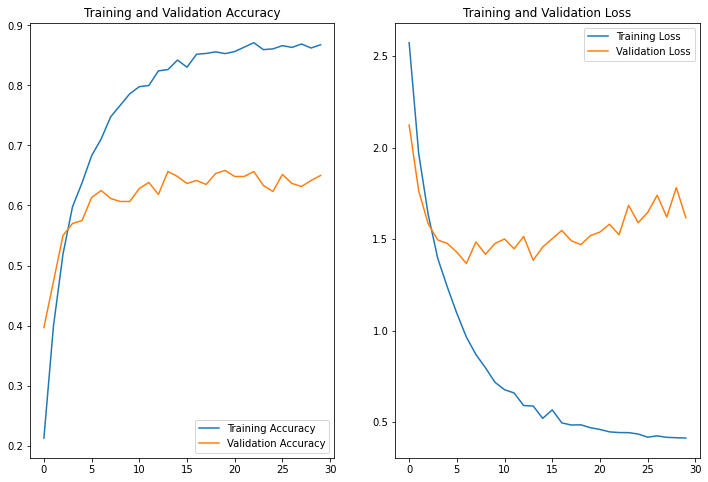

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def subtype_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거

  tokenizer = Tokenizer(num_words=2774, oov_token="<OOV>")
  tokenizer.fit_on_texts(new_sentence)

  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen=maxlen) # 패딩


  # 참조: https://wiserloner.tistory.com/525
  # argsort: 넘파이 배열의 원소를 오름차순 정렬하는 메소드. 반환 값은 배열의 인덱스
  score = model2.predict(pad_new)[0]
  # print(score)
  sort_index = (-score).argsort() # 내림차순 정렬

  for i in sort_index:
    print(sub_type_mapping.get(i))
    # label = [key for key, value in sub_type_mapping.items() if value == i][0]
    # print(label)

  # score = float(model2.predict(pad_new)) # 예측

  # if(score > 0.5):
  #   print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  # else:
  #   print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
subtype_predict('내비게이션이 안 됩니다')

시동
내비게이션
단말기
타이어
경고등
차량내부
주행관련
하이패스
블랙박스
라이트
후방카메라
차량외부
브레이크
주차장
주유/충전카드
사고조사
위생문제
ADAS
비치품
차량점검
충전기확인


In [ ]:
subtype_predict('타이어')

시동
내비게이션
단말기
타이어
경고등
차량내부
주행관련
하이패스
블랙박스
라이트
후방카메라
차량외부
브레이크
주차장
주유/충전카드
사고조사
위생문제
ADAS
비치품
차량점검
충전기확인


In [ ]:
subtype_predict('내비게이션이 t맵 실행준비중으로만 나오고 작동 되지 않음')

경고등
라이트
내비게이션
주행관련
타이어
차량내부
시동
차량외부
단말기
위생문제
주차장
주유/충전카드
후방카메라
ADAS
하이패스
충전기확인
비치품
차량점검
블랙박스
사고조사
브레이크


In [ ]:
subtype_predict('내비게이션 와이파이가 잘 안 됩니다.')

내비게이션
차량내부
타이어
경고등
주행관련
차량외부
후방카메라
블랙박스
시동
브레이크
하이패스
라이트
단말기
주차장
위생문제
사고조사
차량점검
ADAS
주유/충전카드
비치품
충전기확인


In [ ]:
subtype_predict('하이패스 고장')

시동
내비게이션
단말기
타이어
경고등
차량내부
주행관련
하이패스
블랙박스
라이트
후방카메라
차량외부
브레이크
주차장
주유/충전카드
사고조사
위생문제
ADAS
비치품
차량점검
충전기확인


In [ ]:
subtype_predict('시동불가')

시동
내비게이션
단말기
타이어
경고등
차량내부
주행관련
하이패스
블랙박스
라이트
후방카메라
차량외부
브레이크
주차장
주유/충전카드
사고조사
위생문제
ADAS
비치품
차량점검
충전기확인
